In [162]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt

df = pd.read_csv('all_XG_data.csv')
df = df.loc[:, ~df.columns.str.endswith('_speed')]

def get_closest_and_furthest(row, prefix):
    dists = [row[f'{prefix}_{i}_ball_dist'] for i in range(1, 12)]
    dists_sorted = np.sort(dists)
    closest5 = dists_sorted[:5]
    furthest = dists_sorted[-1]
    # Return as a flat list: closest1, ..., closest5, furthest
    return list(closest5) + [furthest]

df = df.drop(columns=['Time', 'Half'])

# Calculate total distance of all players to the ball
for i in range(1, 12):
    df[f'us_{i}_ball_dist'] = np.sqrt((df[f'us_{i}_x'] - df['ball_x'])**2 + (df[f'us_{i}_y'] - df['ball_y'])**2)
    df[f'them_{i}_ball_dist'] = np.sqrt((df[f'them_{i}_x'] - df['ball_x'])**2 + (df[f'them_{i}_y'] - df['ball_y'])**2)

# Optionally, drop the original x/y columns if you only want the distances
player_xy_cols = [f'us_{i}_x' for i in range(1, 12)] + [f'us_{i}_y' for i in range(1, 12)] + \
                 [f'them_{i}_x' for i in range(1, 12)] + [f'them_{i}_y' for i in range(1, 12)]
df = df.drop(columns=player_xy_cols)

df.head()
#df.shape

# ...existing code...


us_features = df.apply(lambda row: get_closest_and_furthest(row, 'us'), axis=1, result_type='expand')
us_features.columns = [f'us_closest_{i+1}' for i in range(5)] + ['us_furthest']
them_features = df.apply(lambda row: get_closest_and_furthest(row, 'them'), axis=1, result_type='expand')
them_features.columns = [f'them_closest_{i+1}' for i in range(5)] + ['them_furthest']

# Build new DataFrame with only relevant features
keep_cols = ['XG', 'ball_x', 'ball_y', 'ball_z']  # add any other columns you want to keep
df = pd.concat([df[keep_cols].reset_index(drop=True), us_features, them_features], axis=1)

df.head()
# ...existing code...


,XG,ball_x,ball_y,ball_z,us_closest_1,us_closest_2,us_closest_3,us_closest_4,us_closest_5,us_furthest,them_closest_1,them_closest_2,them_closest_3,them_closest_4,them_closest_5,them_furthest
0,0.031976,37.01,12.56,1.98,0.734983,6.084546,6.524814,10.785829,13.002231,56.650474,1.416827,6.081127,6.290858,7.160964,7.416266,23.604190
1,0.008036,4.55,-4.36,0.38,0.876812,7.052297,8.076942,8.350024,17.918538,35.162380,6.215609,10.043411,14.216075,16.498151,17.872258,41.497128
2,0.140692,38.81,1.19,0.28,0.843090,7.849108,10.580307,11.490627,12.774275,55.239980,2.916196,5.048733,8.749977,9.206085,11.210446,20.679142
3,0.039328,37.14,13.13,0.33,0.070711,10.135566,11.049366,15.583007,19.120591,69.288401,3.201406,4.522831,7.480802,10.481546,12.031347,29.787897
4,0.032946,39.88,-19.05,0.23,0.774661,10.680918,11.751085,15.543246,18.108611,59.417240,7.174713,8.198451,11.345876,12.987694,13.125075,24.693734


(array([1152.,  290.,  118.,   73.,   45.,   21.,   20.,    5.,   40.,
          17.]),
 array([0.00460289, 0.10192435, 0.19924581, 0.29656727, 0.39388873,
        0.49121018, 0.58853164, 0.6858531 , 0.78317456, 0.88049602,
        0.97781748]),
 <BarContainer object of 10 artists>)

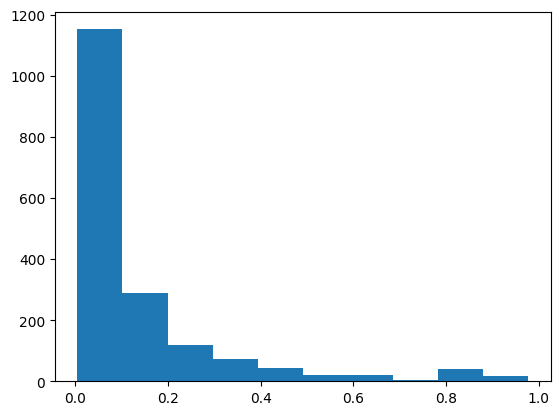

In [163]:
plt.hist(df['XG'])

In [164]:
variables = df.columns
input_variables = variables[variables != 'XG']

X = df[input_variables]
y = df['XG']
y_log = np.log(y)


X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

print(y_train)
print(y)


175    -1.392357
629    -2.827399
1105   -2.288443
1740   -2.381547
1013   -2.434864
          ...   
1130   -0.519634
1294   -1.042099
860    -2.011251
1459   -3.936991
1126   -3.377371
Name: XG, Length: 1424, dtype: float64
0       0.031976
1       0.008036
2       0.140692
3       0.039328
4       0.032946
          ...   
1776    0.140141
1777    0.111705
1778    0.055328
1779    0.048067
1780    0.504271
Name: XG, Length: 1781, dtype: float64


In [166]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

variables = df.columns
input_variables = variables[variables != 'XG']

X = df[input_variables]
y = df['XG']
y_log = np.log(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

xgb = XGBRegressor(objective='reg:squarederror', random_state=90)

search_spaces = {
    'booster': Categorical(['gblinear', 'dart', 'gbtree']),
    'learning_rate': Real(0.001, 0.1, prior='log-uniform'),
    'max_leaves': Integer(20, 70),
    'n_estimators': Integer(50, 200),
    'max_depth': Integer(3, 8),
    'grow_policy': Categorical(['depthwise', 'lossguide']),
}

bayes_search = BayesSearchCV(
    estimator=xgb,
    search_spaces=search_spaces,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=3,
    n_jobs=-1,
    random_state=42
)

bayes_search.fit(X_train, y_train)

print(f"Best Bayesian Search Score: {bayes_search.best_score_:.5f}")
print(f"Best Bayesian Search Parameters: {bayes_search.best_params_}")

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

Mean Absolute Error (MAE): 0.04987452725030127


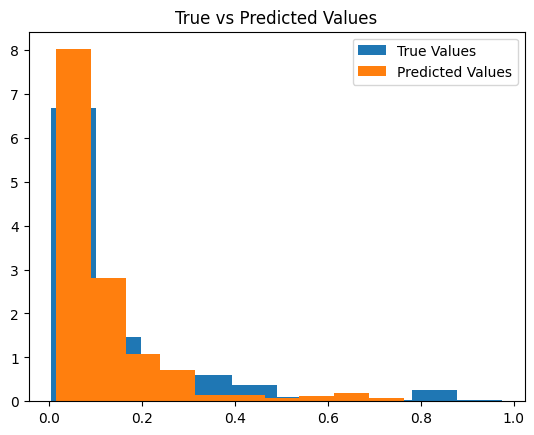

In [169]:
import matplotlib.pyplot as plt
from sklearn.ensemble import BaggingRegressor

def mae(y_true, y_pred):
    return np.mean(abs((y_true - y_pred)))

new_params =  {'booster': 'dart', 'grow_policy': 'lossguide', 'learning_rate': np.float64(0.06630205132311011), 'max_depth': 8, 'max_leaves': 38, 'n_estimators': 328}
new_params =  {'booster': 'dart', 'grow_policy': 'lossguide', 'learning_rate': np.float64(0.06630205132311011), 'max_depth': 8, 'max_leaves': 38, 'n_estimators': 328}

new_params = bayes_search.best_params_
#both new params have mae of about 0.053

xgb_best = XGBRegressor(**new_params, objective='reg:squarederror', random_state=30)

bagged_best = BaggingRegressor(estimator=xgb_best, n_estimators=10, random_state=42)
xgb_best = bagged_best
xgb_best.fit(X_train, y_train)
y_score = xgb_best.predict(X_test)

meow = mae(y_test, y_score)

y_back = np.exp(y_score) 
y_back_test = np.exp(y_test) 
meow_back = mae(y_back_test, y_back)

print(f"Mean Absolute Error (MAE): {meow_back}")

plt.hist(y_back_test, label='True Values', density= True)
plt.hist(y_back, label='Predicted Values', density = True)
plt.title('True vs Predicted Values')
plt.legend()

In [ ]:
print(mae(y_back_test, y_back))


hist, bins = np.histogram(y_back_test, bins=100)
print(hist)

xgb_best.feature_importances_

0.049514768893866475
[ 7 30 40 28 31 33 18 18 15 11  3 12 10  8  4  1  5  1  3  4  4  1  3  3
  2  2  1  4  1  2  2  2  3  2  5  3  0  2  1  1  1  2  3  3  1  1  0  2
  0  0  1  0  0  1  0  0  1  0  0  0  0  0  0  0  0  0  1  3  0  0  0  0
  0  1  0  0  0  0  0  0  8  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  1]


array([0.24332471, 0.20713635, 0.06603321, 0.01401723, 0.02216501,
       0.02396896, 0.05633542, 0.040752  , 0.08060638, 0.09103047,
       0.01989142, 0.02392717, 0.02620698, 0.0231231 , 0.06148165],
      dtype=float32)

C:\Users\nrt\AppData\Local\Temp\ipykernel_2956\1760537452.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=input_variables[sorted_idx])


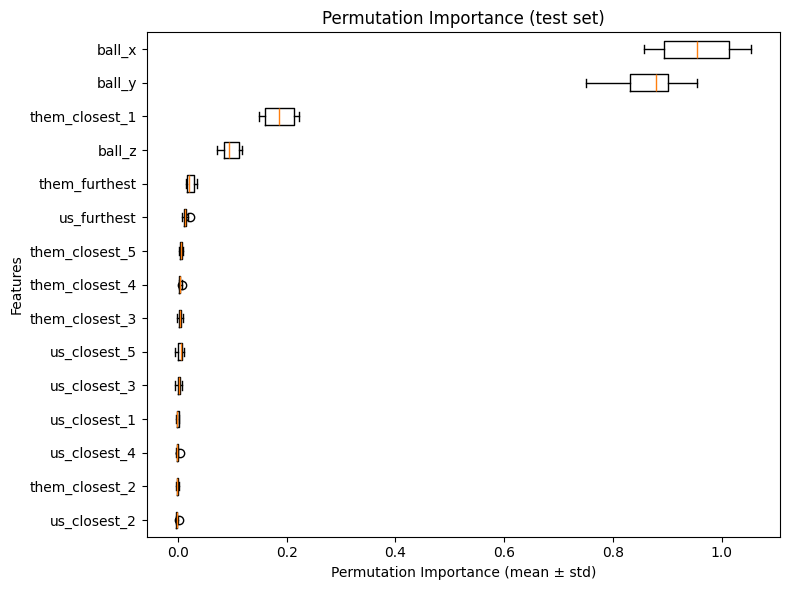

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(xgb_best, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()[::1]

fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=input_variables[sorted_idx])
ax.set_title("Permutation Importance (test set)")
ax.set_xlabel("Permutation Importance (mean ± std)")
ax.set_ylabel("Features")
plt.tight_layout()
plt.show()


Index(['us_closest_2', 'them_closest_2', 'us_closest_4', 'us_closest_1',
       'us_closest_3', 'us_closest_5', 'them_closest_3', 'them_closest_4',
       'them_closest_5', 'us_furthest', 'them_furthest', 'ball_z',
       'them_closest_1', 'ball_y', 'ball_x'],
      dtype='object')


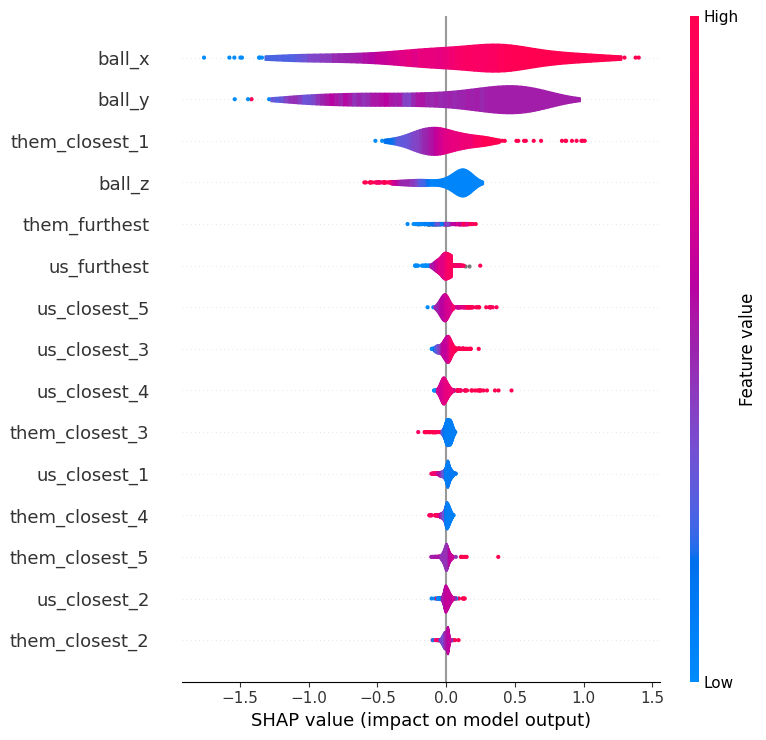

In [ ]:
print(input_variables[sorted_idx])

import shap
# Calculate SHAP values
explainer = shap.TreeExplainer(xgb_best)
shap_values = explainer.shap_values(X_test)

# Plot SHAP values
shap.summary_plot(shap_values, X_test, feature_names=input_variables, plot_type="violin")
plt.show()

In [ ]:
def generate_random_positions(num_positions, x_min, x_max, y_min, y_max,speed_min, speed_max,  z_min, z_max,time_min, time_max):
    data = {}
    rng = np.random.default_rng()
    data['Time'] = rng.integers(time_min, time_max, num_positions)
    data['Half'] = rng.integers(1, 3, num_positions)
    data['ball_x'] = rng.uniform(x_min, x_max, num_positions)
    data['ball_y'] = rng.uniform(y_min, y_max, num_positions)
    data['ball_z'] = rng.uniform(z_min, z_max, num_positions)
    data['ball_speed'] = rng.uniform(speed_min, speed_max, num_positions)
    for i in range(1, 12):
        data[f'us_{i}_x'] = rng.uniform(x_min, x_max, num_positions)
        data[f'us_{i}_y'] = rng.uniform(y_min, y_max, num_positions)
        data[f'us_{i}_speed'] = rng.uniform(speed_min, speed_max, num_positions)
    for i in range(1, 12):
        data[f'them_{i}_x'] = rng.uniform(x_min, x_max, num_positions)
        data[f'them_{i}_y'] = rng.uniform(y_min, y_max, num_positions)
        data[f'them_{i}_speed'] = rng.uniform(speed_min, speed_max, num_positions)
    df_random = pd.DataFrame(data)
    return df_random

def xg_and_plot(random_line):
    xg = np.exp(xgb_best.predict(random_line))
    fig, ax = plt.subplots()
    ax.scatter(random_line['ball_x'], random_line['ball_y'], cmap='viridis', s=10)
    for i in range(1, 12):
        ax.scatter(random_line[f'us_{i}_x'], random_line[f'us_{i}_y'], c='blue', s=10)
        ax.scatter(random_line[f'them_{i}_x'], random_line[f'them_{i}_y'], c='red', s=10)
    ax.annotate(f'XG: {xg[0]:.2f}', xy=(random_line['ball_x'][0], random_line['ball_y'][0]), fontsize=12, color='black')
    return fig

In [ ]:
random_line = generate_random_positions(1, 0, 50, -10, 10, 0, 5, 0, 5, 0, 50000)
fig = xg_and_plot(random_line)
plt.legend([ 'Ball', 'Us', 'Them'])
plt.show()

ValueError: feature_names mismatch: ['ball_x', 'ball_y', 'ball_z', 'us_closest_1', 'us_closest_2', 'us_closest_3', 'us_closest_4', 'us_closest_5', 'us_furthest', 'them_closest_1', 'them_closest_2', 'them_closest_3', 'them_closest_4', 'them_closest_5', 'them_furthest'] ['Time', 'Half', 'ball_x', 'ball_y', 'ball_z', 'ball_speed', 'us_1_x', 'us_1_y', 'us_1_speed', 'us_2_x', 'us_2_y', 'us_2_speed', 'us_3_x', 'us_3_y', 'us_3_speed', 'us_4_x', 'us_4_y', 'us_4_speed', 'us_5_x', 'us_5_y', 'us_5_speed', 'us_6_x', 'us_6_y', 'us_6_speed', 'us_7_x', 'us_7_y', 'us_7_speed', 'us_8_x', 'us_8_y', 'us_8_speed', 'us_9_x', 'us_9_y', 'us_9_speed', 'us_10_x', 'us_10_y', 'us_10_speed', 'us_11_x', 'us_11_y', 'us_11_speed', 'them_1_x', 'them_1_y', 'them_1_speed', 'them_2_x', 'them_2_y', 'them_2_speed', 'them_3_x', 'them_3_y', 'them_3_speed', 'them_4_x', 'them_4_y', 'them_4_speed', 'them_5_x', 'them_5_y', 'them_5_speed', 'them_6_x', 'them_6_y', 'them_6_speed', 'them_7_x', 'them_7_y', 'them_7_speed', 'them_8_x', 'them_8_y', 'them_8_speed', 'them_9_x', 'them_9_y', 'them_9_speed', 'them_10_x', 'them_10_y', 'them_10_speed', 'them_11_x', 'them_11_y', 'them_11_speed']
expected us_closest_1, us_furthest, them_furthest, them_closest_5, them_closest_3, us_closest_2, us_closest_4, us_closest_5, us_closest_3, them_closest_2, them_closest_4, them_closest_1 in input data
training data did not have the following fields: them_3_x, us_11_x, them_1_y, them_2_speed, us_2_y, us_9_speed, them_10_x, them_8_x, them_2_y, us_4_speed, us_7_x, them_5_speed, us_8_x, them_7_y, us_1_speed, them_11_x, us_10_y, them_2_x, them_9_y, them_4_y, us_9_y, them_9_speed, us_4_x, us_3_y, them_1_x, us_5_y, us_3_speed, them_5_y, us_6_x, them_11_speed, them_6_y, them_6_x, Time, us_2_speed, them_10_speed, Half, us_1_x, us_7_y, them_7_speed, ball_speed, them_1_speed, them_3_speed, them_4_speed, us_5_x, us_5_speed, them_8_y, us_6_y, us_3_x, us_9_x, them_6_speed, them_8_speed, them_10_y, us_7_speed, them_5_x, us_8_y, them_11_y, us_4_y, us_6_speed, us_11_speed, them_3_y, us_2_x, us_8_speed, them_4_x, us_10_speed, us_10_x, us_1_y, them_9_x, them_7_x, us_11_y